In [1]:
import time
import copy
from collections import defaultdict
import numpy as np

# Simple RL
from simple_rl.tasks import GridWorldMDP
from simple_rl.planning import ValueIteration

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def run_value_iteration(S, A, R, trans_dict, s_to_idx, gamma, n_iters, expl_policy, dtype, given_goal_idx=None):
    
    nS, nA = len(S), len(A)
    # Policy
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    # Value
    V = R[:,0].clone()
    # Q value
    Q = R.repeat(1,nA).clone()
    
    if given_goal_idx:
        V[given_goal_idx] = 0
    
    # Value iteration
    for _vi_iter in range(n_iters):
        for s_idx, s in enumerate(S):
            # Check if state is terminal (stop leaking values back to non-goal state space)
            if s.is_terminal() or (given_goal_idx and s_idx == given_goal_idx):
                continue
            for a_idx, a in enumerate(A):
                
                Q[s_idx, a_idx] = R[s_idx]
                for s_prime in trans_dict[s][a]:
                    Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[s_to_idx[s_prime]].clone()
                Pi[s_idx, :] = expl_policy(Q[s_idx,:].clone())
                V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
    return Pi, V, Q

def compute_loss(Pi, traj_S, traj_A):
    
    nS, nA = Pi.shape
    loss = 0.
    for i in range(len(traj_S)):
        loss -= torch.log(Pi[traj_S[i], traj_A[i]])
    return loss

def dummy_max_likelihood_gradient_step(Pi, n_samples):
    
    nS, nA = Pi.shape
    traj_S = [np.random.choice(nS) for _ in range(n_samples)]
    traj_A = [np.random.choice(nA) for _ in range(n_samples)]
    loss = compute_loss(Pi, traj_S, traj_A)
    loss.backward()
    
def run_dummy_mlirl(phi_S, w, vi_vars, n_iters, n_traj_points, optimizer):
    
    optimizer.zero_grad()
    vi_vars["R"] = torch.mm(phi_S, w)
    Pi, V, Q = run_value_iteration(**vi_vars, n_iters=n_iters)
    dummy_max_likelihood_gradient_step(Pi, n_traj_points)

def compute_perf(fn, var_values, n_rep):
    
    run_times = []
    for var_value in var_values:
        
        ts = time.time()
        for _ in range(n_rep):
            fn(var_value)
        run_times.append((time.time()-ts)/n_rep)
        
    return run_times

### GridWorld MDP (3x5)

In [3]:
mdp = GridWorldMDP()
value_iter = ValueIteration(mdp)
value_iter._compute_matrix_from_trans_func()

S = value_iter.get_states()
trans_dict = value_iter.trans_dict
A = mdp.get_actions()
s_to_idx = {s:idx for idx,s in enumerate(S)}

dtype = torch.float
phi_S = torch.Tensor([(s.x, s.y) for s in S]).type(dtype)
phi_dim = phi_S.shape[1]

w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
R = torch.mm(phi_S, w)
R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)

gamma = 0.95
boltzmann_beta = 1.
expl_policy = lambda Q: (boltzmann_beta*Q).softmax(dim=0)

given_goal_idx = None

# Optimization params
optimizer_fn = lambda params: optim.SGD(params, lr=0.1, weight_decay=1.)
optimizer = optimizer_fn([w])

vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
               gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)

In [4]:
iter_range = list(range(1,11)) + list(range(20,110,10)) + [150,200,250,300,350,400,500]
n_rep = 10
n_traj_points = 10

vi_vars["R"] = R_const
rt_vi_no_diff_param = compute_perf(lambda n_iters: run_value_iteration(**vi_vars, n_iters=n_iters), 
                          iter_range, n_rep)
vi_vars["R"] = R
rt_vi_diff_param = compute_perf(lambda n_iters: run_value_iteration(**vi_vars, n_iters=n_iters), 
                       iter_range, n_rep)
rt_vi_backward = compute_perf(lambda n_iters: run_dummy_mlirl(phi_S, w, vi_vars, n_iters=n_iters, 
                                                                n_traj_points=n_traj_points,
                                                                optimizer=optimizer),
                                iter_range, n_rep)

In [5]:
mean_iter = lambda x: (np.array(x) / iter_range).mean()
mean_rt_vi_no_diff_param = mean_iter(rt_vi_no_diff_param)
mean_rt_vi_diff_param = mean_iter(rt_vi_diff_param)
mean_rt_vi_backward = mean_iter(rt_vi_backward)

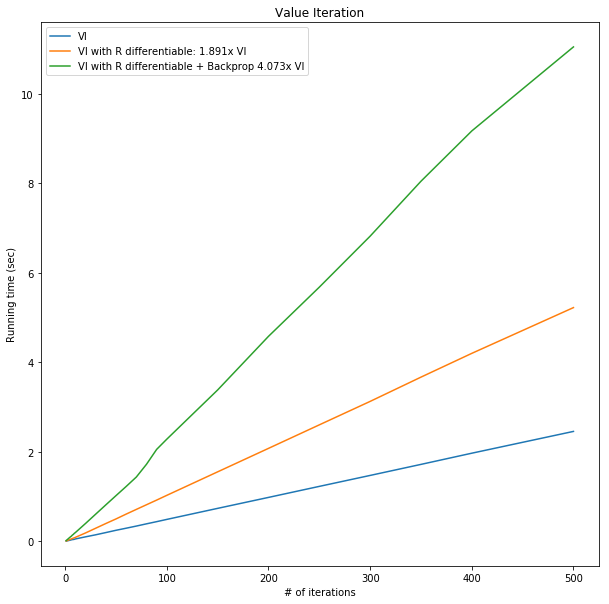

In [10]:
plt.figure(figsize=(10,10))
plt.plot(iter_range, rt_vi_no_diff_param, label="VI")
plt.plot(iter_range, rt_vi_diff_param, label="VI with R differentiable: {:.3f}x VI".format(
                                                                        mean_rt_vi_diff_param/mean_rt_vi_no_diff_param))
plt.plot(iter_range, rt_vi_backward, label="VI with R differentiable + Backprop {:.3f}x VI".format(
                                                                        mean_rt_vi_backward/mean_rt_vi_no_diff_param))
plt.title("Value Iteration")
plt.xlabel("# of iterations")
plt.ylabel("Running time (sec)")
plt.legend()

In [7]:
n_traj_point_range = list(range(1,11)) + list(range(20,110,10)) + [150,200,250,300,350,400,500]
rt_vi_backward_ = compute_perf(lambda n_traj_points: run_dummy_mlirl(phi_S, w, vi_vars, n_iters=10,
                                                                n_traj_points=n_traj_points,
                                                                optimizer=optimizer),
                                n_traj_point_range, n_rep)

Text(0,0.5,'Running time (sec)')

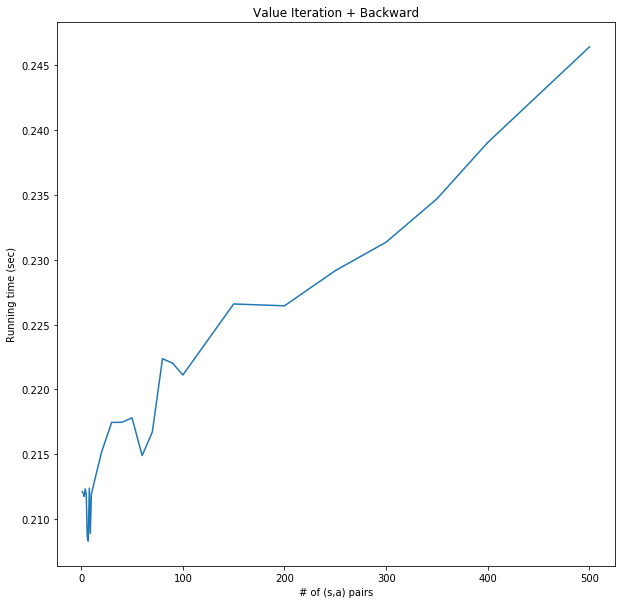

In [11]:
plt.figure(figsize=(10,10))
plt.plot(n_traj_point_range, rt_vi_backward_)
plt.title("Value Iteration + Backward")
plt.xlabel("# of (s,a) pairs")
plt.ylabel("Running time (sec)")